In [30]:
import os
import sys
import cv2
import torch
import numpy as np
import albumentations as A
import torch.optim as optim
import torch.utils.data as dt
import matplotlib.pyplot as plt
import torchvision.transforms as tf
import segmentation_models_pytorch as smp

from tqdm import tqdm
from imutils import paths
from torchmetrics import JaccardIndex
from sklearn.model_selection import train_test_split

epoch = 1
data_path = "DATASET/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
memory = True if device == 'cuda' else False

In [31]:
def image_resize(img):
    height = img.shape[0]
    width = img.shape[1]
    problem = abs(height - width)
    sz = [int(problem / 2), problem - int(problem / 2), 0]
    if width >= height:
        img = cv2.copyMakeBorder(
            img, sz[0], sz[1], sz[2], sz[2], cv2.BORDER_CONSTANT)
    else:
        img = cv2.copyMakeBorder(
            img, sz[2], sz[2], sz[0], sz[1], cv2.BORDER_CONSTANT)
    img = cv2.resize(img, (224, 224))
    return img

In [32]:
class SegmentationDataset(dt.Dataset):
    def __init__(self, imagPaths, maskPaths, transforms, transforms_affine=None):
        self.imagPaths = imagPaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        self.transforms_affine = transforms_affine

    def __len__(self):
        return len(self.imagPaths)

    def __getitem__(self, idx):
        imag = cv2.imread(self.imagPaths[idx], cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_GRAYSCALE)
        imag = image_resize(imag)
        mask = image_resize(mask)
        if self.transforms_affine != None:
            transformed = self.transforms_affine(image=imag, mask=mask)
            imag = transformed["image"]
            mask = transformed["mask"]
        imag = self.transforms(imag)
        mask = tf.Compose([tf.ToTensor()])(mask)
        return imag, mask

In [33]:
class SegmentationTestDataset(dt.Dataset):
    def __init__(self, imagPaths, maskPaths, transforms):
        self.imagPaths = imagPaths
        self.maskPaths = maskPaths
        self.transforms = transforms

    def __len__(self):
        return len(self.imagPaths)

    def __getitem__(self, idx):
        imag = cv2.imread(self.imagPaths[idx], cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_GRAYSCALE)
        imag = image_resize(imag)
        mask = image_resize(mask)
        real = tf.Compose([tf.ToTensor()])(imag)
        mask = tf.Compose([tf.ToTensor()])(mask)
        imag = self.transforms(imag)
        return real, imag, mask

In [34]:
def get_mean_std(train_loader):
    mean = torch.tensor([0., 0., 0.])
    std = torch.tensor([0., 0., 0.])
    for data in train_loader:
        img, mask = data
        mean += img.mean([0, 2, 3])
        std += img.std([0, 2, 3])
    mean /= len(train_loader)
    std /= len(train_loader)
    return mean, std

In [35]:
bad_batch_size = 4
bad_Paths = sorted(list(paths.list_images(data_path + "gen_smoke_bad")))
bad_mask_Paths = sorted(
    list(paths.list_images(data_path + "gen_smoke_bad_masks")))
split_bad = train_test_split(bad_Paths, bad_mask_Paths, test_size=0.2)
(train_bad_imag, test_bad_imag) = split_bad[:2]
(train_bad_mask, test_bad_mask) = split_bad[2:]

blender_batch_size = 4
blender_Paths = sorted(list(paths.list_images(data_path + "blender_smoke")))
blender_mask_Paths = sorted(
    list(paths.list_images(data_path + "blender_smoke_masks")))
split_blender = train_test_split(blender_Paths, blender_mask_Paths, test_size=0.2)
(train_blender_imag, test_blender_imag) = split_blender[:2]
(train_blender_mask, test_blender_mask) = split_blender[2:]

good_batch_size = 4
good_Paths = sorted(list(paths.list_images(data_path + "orig_smoke")))
good_mask_Paths = sorted(
    list(paths.list_images(data_path + "orig_smoke_masks")))
split_good = train_test_split(good_Paths, good_mask_Paths, test_size=0.2)
(train_good_imag, test_good_imag) = split_good[:2]
(train_good_mask, test_good_mask) = split_good[2:]

test_batch_size = 1
test_Paths = sorted(list(paths.list_images(data_path + 'test')))
test_masks_Path = sorted(list(paths.list_images(data_path + 'test_mask')))

In [36]:
transform_bad = tf.Compose([tf.ToTensor()])
bad_imag_train = SegmentationDataset(
    train_bad_imag, train_bad_mask, transform_bad)
bad_imag_test = SegmentationDataset(
    test_bad_imag, test_bad_mask, transform_bad)
bad_dataset_train = dt.DataLoader(bad_imag_train, batch_size=bad_batch_size, shuffle=True,
                                  pin_memory=memory, num_workers=os.cpu_count())
bad_dataset_test = dt.DataLoader(bad_imag_test, batch_size=bad_batch_size, shuffle=False,
                                 pin_memory=memory, num_workers=os.cpu_count())
bad_mean, bad_std = get_mean_std(bad_dataset_train)

transform_blender = tf.Compose([tf.ToTensor()])
blender_imag_train = SegmentationDataset(
    train_blender_imag, train_blender_mask, transform_blender)
blender_imag_test = SegmentationDataset(
    test_blender_imag, test_blender_mask, transform_blender)
blender_dataset_train = dt.DataLoader(blender_imag_train, batch_size=blender_batch_size, shuffle=True,
                                  pin_memory=memory, num_workers=os.cpu_count())
blender_dataset_test = dt.DataLoader(blender_imag_test, batch_size=blender_batch_size, shuffle=False,
                                 pin_memory=memory, num_workers=os.cpu_count())
blender_mean, blender_std = get_mean_std(blender_dataset_train)

transform_good = tf.Compose([tf.ToTensor()])
good_imag_train = SegmentationDataset(
    train_good_imag, train_good_mask, transform_good)
good_imag_test = SegmentationDataset(
    test_good_imag, test_good_mask, transform_good)
good_dataset_train = dt.DataLoader(good_imag_train, batch_size=good_batch_size, shuffle=True,
                                   pin_memory=memory, num_workers=os.cpu_count())
good_dataset_test = dt.DataLoader(good_imag_test, batch_size=good_batch_size, shuffle=False,
                                  pin_memory=memory, num_workers=os.cpu_count())
good_mean, good_std = get_mean_std(good_dataset_train)

transform_test = tf.Compose([tf.ToTensor()])
test_imag = SegmentationTestDataset(
    test_Paths, test_masks_Path, transform_test)
test_dataset = dt.DataLoader(test_imag, batch_size=test_batch_size, shuffle=False,
                             pin_memory=memory, num_workers=os.cpu_count())

In [37]:
transform_bad = tf.Compose([tf.ToTensor(), tf.Normalize(bad_mean, bad_std),
                            tf.GaussianBlur(kernel_size=(7, 13), sigma=(0.25, 0.5))])
bad_imag_train = SegmentationDataset(
    train_bad_imag, train_bad_mask, transform_bad)
bad_imag_test = SegmentationDataset(
    test_bad_imag, test_bad_mask, transform_bad)
bad_dataset_train = dt.DataLoader(bad_imag_train, batch_size=bad_batch_size, shuffle=True,
                                  pin_memory=memory, num_workers=os.cpu_count())
bad_dataset_test = dt.DataLoader(bad_imag_test, batch_size=bad_batch_size, shuffle=False,
                                 pin_memory=memory, num_workers=os.cpu_count())

transform_blender = tf.Compose([tf.ToTensor(), tf.Normalize(blender_mean, blender_std),
                            tf.GaussianBlur(kernel_size=(7, 13), sigma=(0.25, 0.5))])
blender_imag_train = SegmentationDataset(
    train_blender_imag, train_blender_mask, transform_blender)
blender_imag_test = SegmentationDataset(
    test_blender_imag, test_blender_mask, transform_blender)
blender_dataset_train = dt.DataLoader(blender_imag_train, batch_size=blender_batch_size, shuffle=True,
                                  pin_memory=memory, num_workers=os.cpu_count())
blender_dataset_test = dt.DataLoader(blender_imag_test, batch_size=blender_batch_size, shuffle=False,
                                 pin_memory=memory, num_workers=os.cpu_count())

transform_good = tf.Compose([tf.ToTensor(), tf.Normalize(good_mean, good_std)])
transform_good_affine = A.Compose([A.Perspective(scale=(0.05, 0.3), p=1.),
                                   A.Affine(rotate=25, scale=(0.9, 0.9)),
                                   A.HorizontalFlip(p=.5)])
good_imag_train = SegmentationDataset(
    train_good_imag, train_good_mask, transform_good)
good_imag_test = SegmentationDataset(
    test_good_imag, test_good_mask, transform_good)
good_imag_train_trans = SegmentationDataset(
    train_good_imag, train_good_mask, transform_good, transform_good_affine)
good_imag_test_trans = SegmentationDataset(
    test_good_imag, test_good_mask, transform_good, transform_good_affine)
good_imag_train = dt.ConcatDataset([good_imag_train, good_imag_train_trans])
good_imag_test = dt.ConcatDataset([good_imag_test, good_imag_test_trans])
good_dataset_train = dt.DataLoader(good_imag_train, batch_size=good_batch_size, shuffle=True,
                                   pin_memory=memory, num_workers=os.cpu_count())
good_dataset_test = dt.DataLoader(good_imag_test, batch_size=good_batch_size, shuffle=False,
                                  pin_memory=memory, num_workers=os.cpu_count())

transform_test = tf.Compose([tf.ToTensor(), tf.Normalize(good_mean, good_std)])
test_imag = SegmentationTestDataset(
    test_Paths, test_masks_Path, transform_test)
test_dataset = dt.DataLoader(test_imag, batch_size=test_batch_size, shuffle=False,
                             pin_memory=memory, num_workers=os.cpu_count())

In [38]:
def draw_plot(H):
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 10))
    plt.plot(np.arange(1, len(H["loss"])+1), H["loss"], label="loss")
    plt.plot(np.arange(1, len(H["accu"])+1), H["accu"], label="accu")
    plt.title("Training Loss and Accu")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

In [39]:
model = smp.MAnet(
    encoder_name="efficientnet-b7",
    encoder_depth=5,
    encoder_weights='imagenet',
    activation='sigmoid'
).to(device)

loss_func = torch.nn.BCELoss().to(device)
accu_func = JaccardIndex(num_classes=2).to(device)

In [40]:
def train(loss_fn, accu_func, train_loader, test_loader, learning_rate=1e-4, num_epoch=5, scheduler=5):
    global epoch, model, H
    best_epoch = 0
    best_epoch_ind = 0
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    for e in range(num_epoch):
        model.train()
        totalLoss = 0
        totalAccu = 0
        if (e + 1) % scheduler == 0:
            learning_rate /= scheduler
        for (i, (x, y)) in tqdm(enumerate(train_loader), total=len(train_loader)):
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            loss = loss_func(pred.squeeze(1), y.squeeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            totalLoss += loss
        with torch.no_grad():
            model.eval()
            for (x, y) in test_loader:
                (x, y) = (x.to(device), y.to(device))
                pred = model(x)
                accu = accu_func(pred.squeeze(1), y.squeeze(1) > 0.5)
                totalAccu += accu

        avgLoss = totalLoss / len(train_loader)
        avgAccu = totalAccu / len(test_loader)
        H["loss"].append(avgLoss.cpu().detach().numpy())
        H["accu"].append(avgAccu.cpu().detach().numpy())
        print("[INFO] EPOCH: {}".format(epoch))
        print("loss: {:.4f}, accu: {:.4f}\n".format(avgLoss, avgAccu))

        if best_epoch < avgAccu:
            best_epoch = avgAccu
            best_epoch_ind = epoch
        torch.save(model.state_dict(),
                   "EPOCH/model_weights-" + str(epoch) + ".pth")
        epoch += 1
    model.load_state_dict(torch.load("EPOCH/model_weights-" +
                          str(best_epoch_ind) + ".pth", map_location=torch.device(device)))

100%|██████████| 602/602 [03:47<00:00,  2.65it/s]


[INFO] EPOCH: 1
loss: 0.1636, accu: 0.9681



100%|██████████| 602/602 [03:27<00:00,  2.90it/s]


[INFO] EPOCH: 2
loss: 0.0414, accu: 0.9782



100%|██████████| 602/602 [03:29<00:00,  2.88it/s]


[INFO] EPOCH: 3
loss: 0.0276, accu: 0.9798



100%|██████████| 602/602 [03:27<00:00,  2.90it/s]


[INFO] EPOCH: 4
loss: 0.0248, accu: 0.9797



100%|██████████| 602/602 [03:27<00:00,  2.90it/s]


[INFO] EPOCH: 5
loss: 0.0236, accu: 0.9824



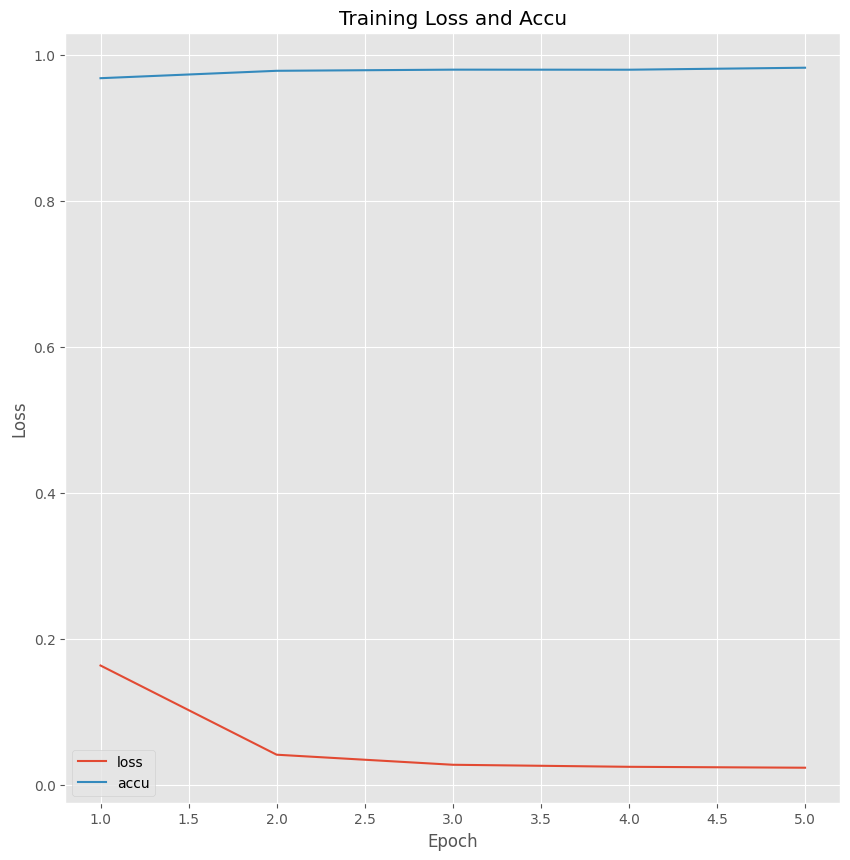

In [41]:
H = {"loss": [], "accu": []}
train(loss_func, accu_func, bad_dataset_train, bad_dataset_test, num_epoch=5)
draw_plot(H)

100%|██████████| 137/137 [00:47<00:00,  2.90it/s]


[INFO] EPOCH: 6
loss: 0.1663, accu: 0.8587



100%|██████████| 137/137 [00:47<00:00,  2.90it/s]


[INFO] EPOCH: 7
loss: 0.0772, accu: 0.8915



100%|██████████| 137/137 [00:47<00:00,  2.89it/s]


[INFO] EPOCH: 8
loss: 0.0641, accu: 0.9030



100%|██████████| 137/137 [00:47<00:00,  2.90it/s]


[INFO] EPOCH: 9
loss: 0.0544, accu: 0.9089



100%|██████████| 137/137 [00:47<00:00,  2.89it/s]


[INFO] EPOCH: 10
loss: 0.0500, accu: 0.9145



100%|██████████| 137/137 [00:47<00:00,  2.89it/s]


[INFO] EPOCH: 11
loss: 0.0488, accu: 0.9181



100%|██████████| 137/137 [00:47<00:00,  2.90it/s]


[INFO] EPOCH: 12
loss: 0.0455, accu: 0.9208



100%|██████████| 137/137 [00:47<00:00,  2.89it/s]


[INFO] EPOCH: 13
loss: 0.0441, accu: 0.9131



100%|██████████| 137/137 [00:47<00:00,  2.89it/s]


[INFO] EPOCH: 14
loss: 0.0419, accu: 0.9243



100%|██████████| 137/137 [00:47<00:00,  2.89it/s]


[INFO] EPOCH: 15
loss: 0.0415, accu: 0.9257



100%|██████████| 137/137 [00:47<00:00,  2.88it/s]


[INFO] EPOCH: 16
loss: 0.0397, accu: 0.9266



100%|██████████| 137/137 [00:47<00:00,  2.88it/s]


[INFO] EPOCH: 17
loss: 0.0389, accu: 0.9278



100%|██████████| 137/137 [00:47<00:00,  2.88it/s]


[INFO] EPOCH: 18
loss: 0.0387, accu: 0.9263



100%|██████████| 137/137 [00:47<00:00,  2.88it/s]


[INFO] EPOCH: 19
loss: 0.0380, accu: 0.9287



100%|██████████| 137/137 [00:47<00:00,  2.88it/s]


[INFO] EPOCH: 20
loss: 0.0376, accu: 0.9281



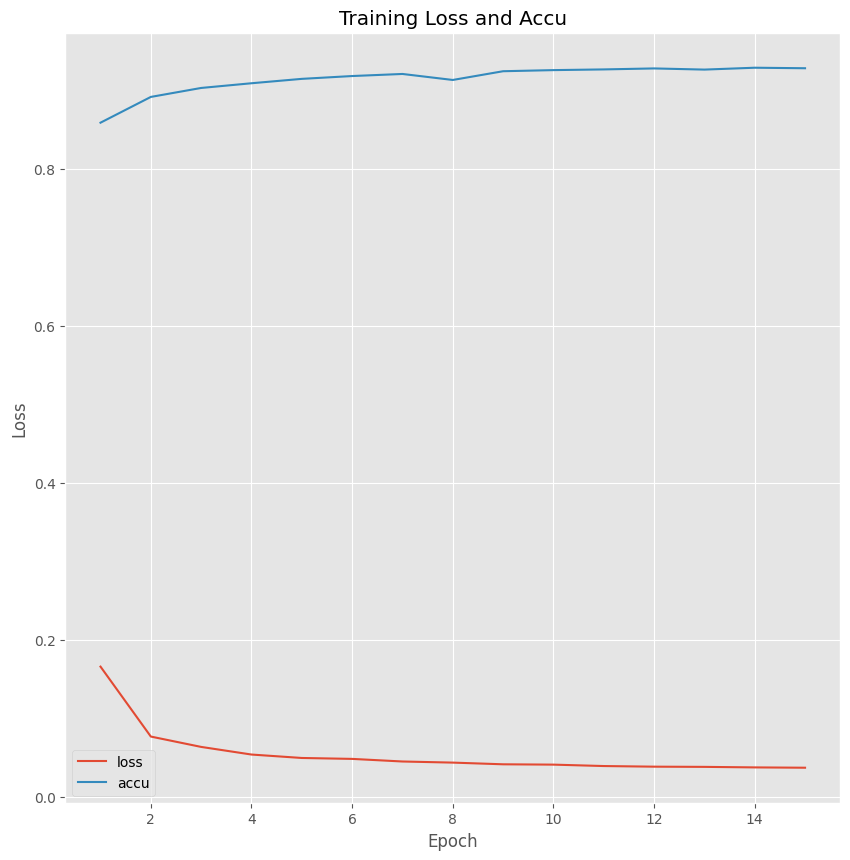

In [42]:
H = {"loss": [], "accu": []}
train(loss_func, accu_func, blender_dataset_train, blender_dataset_test, num_epoch=15)
draw_plot(H)

100%|██████████| 114/114 [00:39<00:00,  2.89it/s]


[INFO] EPOCH: 21
loss: 0.3190, accu: 0.7634



100%|██████████| 114/114 [00:39<00:00,  2.90it/s]


[INFO] EPOCH: 22
loss: 0.2063, accu: 0.7694



100%|██████████| 114/114 [00:40<00:00,  2.81it/s]


[INFO] EPOCH: 23
loss: 0.1604, accu: 0.8139



100%|██████████| 114/114 [00:39<00:00,  2.87it/s]


[INFO] EPOCH: 24
loss: 0.1466, accu: 0.8094



100%|██████████| 114/114 [00:39<00:00,  2.90it/s]


[INFO] EPOCH: 25
loss: 0.1357, accu: 0.8338



100%|██████████| 114/114 [00:39<00:00,  2.90it/s]


[INFO] EPOCH: 26
loss: 0.1355, accu: 0.8314



100%|██████████| 114/114 [00:39<00:00,  2.88it/s]


[INFO] EPOCH: 27
loss: 0.1393, accu: 0.8370



100%|██████████| 114/114 [00:39<00:00,  2.88it/s]


[INFO] EPOCH: 28
loss: 0.1302, accu: 0.8296



100%|██████████| 114/114 [00:39<00:00,  2.88it/s]


[INFO] EPOCH: 29
loss: 0.1147, accu: 0.8366



100%|██████████| 114/114 [00:39<00:00,  2.90it/s]


[INFO] EPOCH: 30
loss: 0.1198, accu: 0.8458



100%|██████████| 114/114 [00:39<00:00,  2.89it/s]


[INFO] EPOCH: 31
loss: 0.1048, accu: 0.7972



100%|██████████| 114/114 [00:39<00:00,  2.89it/s]


[INFO] EPOCH: 32
loss: 0.1100, accu: 0.8498



100%|██████████| 114/114 [00:39<00:00,  2.87it/s]


[INFO] EPOCH: 33
loss: 0.1092, accu: 0.8249



100%|██████████| 114/114 [00:39<00:00,  2.88it/s]


[INFO] EPOCH: 34
loss: 0.0971, accu: 0.8348



100%|██████████| 114/114 [00:39<00:00,  2.88it/s]


[INFO] EPOCH: 35
loss: 0.1112, accu: 0.8373



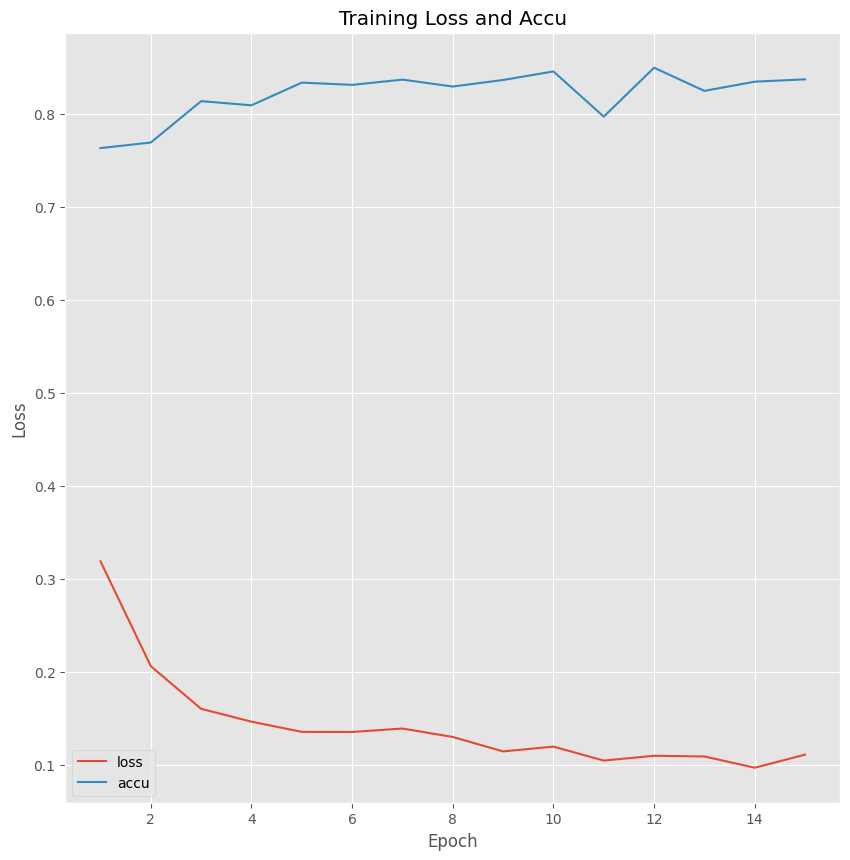

In [43]:
H = {"loss": [], "accu": []}
train(loss_func, accu_func, good_dataset_train, good_dataset_test, num_epoch=15)
draw_plot(H)

AVG accu: 0.8406


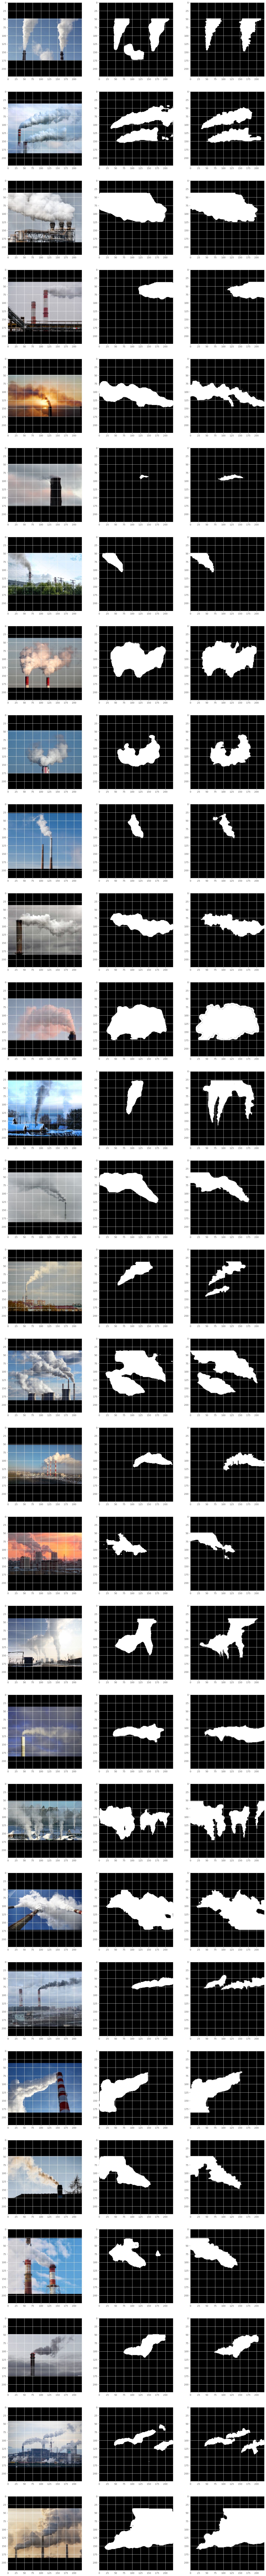

In [44]:
totalAccu = 0
fig, ax = plt.subplots(len(test_Paths), 3, figsize=(20, 200))
with torch.no_grad():
    model.eval()
    for (i, (r, x, y)) in enumerate(test_dataset):
        (r, x, y) = (r.to(device), x.to(device), y.to(device))
        p = model(x)
        ax[i][0].imshow(cv2.cvtColor(np.clip(
            r.squeeze(0).cpu().numpy().transpose(1, 2, 0), 0, 1), cv2.COLOR_RGB2BGR))
        ax[i][1].imshow(cv2.cvtColor(p.squeeze(0).cpu().numpy(
        ).round().transpose(1, 2, 0), cv2.IMREAD_GRAYSCALE))
        ax[i][2].imshow(cv2.cvtColor(
            y.squeeze(0).cpu().numpy().transpose(1, 2, 0), cv2.IMREAD_GRAYSCALE))
        totalAccu += accu_func(p.squeeze(1), y.squeeze(1) > 0.5)
avgAccu = totalAccu / len(test_dataset)
print("AVG accu: {:.4f}".format(avgAccu))

In [ ]:
# torch.save(model.state_dict(), "BEST model/29.09.pth")

In [11]:
# model.load_state_dict(torch.load("BEST model/05.11.pth", map_location=torch.device(device)))

<All keys matched successfully>

In [12]:
def write_video(file_path, frames, fps):
    num, w, h, ch = frames.shape
    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

    for frame in frames:
        writer.write(np.uint8(frame))

    writer.release()

In [27]:
def check_dist(prev_p, p, r=10):
    for i in range(p.shape[0]):
        for j in range(p.shape[1]):
            if(prev_p[max(0,i-r):min(p.shape[0], i + r),max(0,j-r):min(p.shape[1], j + r)].sum() == 0):
                p[i,j] = 0
    return p

In [23]:
def read_video(file_path, skip=10):
    global model
    video = cv2.VideoCapture(file_path)
    transforms = tf.Compose([tf.ToTensor(), tf.Normalize(good_mean, good_std)])
    images = []
    num_frame = 0
    prev_p = np.nan
    with torch.no_grad():
        model.eval()
        while (video.isOpened()):
            num_frame += 1
            flag, x = video.read()
            if flag:
                x = image_resize(x)
                p = model(transforms(x).to(device).unsqueeze(0))
                p = p.cpu().numpy().squeeze()
                x = cv2.normalize(x, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_16U)
                p = np.expand_dims(cv2.normalize(
                    p.round(), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_16U), axis=2)

                if num_frame > skip:
                    p = check_dist(prev_p, p)
                    prev_p = p
                elif num_frame < skip:
                    if (num_frame == 1):
                        prev_p = p
                    else:
                        prev_p += p
                else:
                    prev_p += prev_p
                    prev_p //= skip

                x[:, :, 1] = np.where(
                    p[:, :, 0] != 255, x[:, :, 1], x[:, :, 1] * 0.7)
                x[:, :, 0] = np.where(
                    p[:, :, 0] != 255, x[:, :, 0], x[:, :, 0] * 0.7)
                x[:, :, 2] = np.where(
                    p[:, :, 0] != 255, x[:, :, 2], x[:, :, 2] * 0.7 + p[:, :, 0] * 0.3)
                images.append(x)
                if (num_frame == 300):
                    break
            else:
                break
    video.release()
    return np.array(images)

In [29]:
images = read_video('DATASET/video/1.mp4')
write_video('vidMOD.avi', images, 30)